# Data Preprocessing for Human Infrastructure Detection

This notebook handles preprocessing of the Landcover.ai dataset for training segmentation models.

**Dataset**: Landcover.ai v1
- 41 GeoTIFF images of aerial imagery from Poland
- 512×512 pixel tiles
- 5 land cover classes: Background, Building, Woodland, Water, Road

**Steps**:
1. Explore raw data structure
2. Tile raw TIFs into training tiles
3. Analyze class distribution
4. Verify processed data
5. Calculate class weights for training

## 1. Setup and Configuration

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
DATA_ROOT = Path('../data')
LANDCOVER_DIR = DATA_ROOT / 'landcover.ai.v1'

PLOTS_DIR = Path('../plots/landcover')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Class definitions
CLASS_NAMES = ['background', 'building', 'woodland', 'water', 'road']
NUM_CLASSES = len(CLASS_NAMES)

CLASS_COLORS = {
    0: [0.8, 0.8, 0.8],    # Background - gray
    1: [1.0, 0.0, 0.0],    # Building - red
    2: [0.0, 0.5, 0.0],    # Woodland - dark green
    3: [0.0, 0.0, 1.0],    # Water - blue
    4: [1.0, 0.0, 1.0],    # Road - magenta
}

print(f"Data root: {DATA_ROOT.absolute()}")
print(f"Landcover.ai directory: {LANDCOVER_DIR}")

Data root: c:\vscode workspace\ml-mangrove\DroneClassification\human_infra\01_data_preprocessing\..\data
Landcover.ai directory: ..\data\landcover.ai.v1


## 2. Explore Raw Data Structure

In [2]:
# Check what's in the landcover directory
print("=== Landcover.ai Directory Structure ===")
print()

for item in sorted(LANDCOVER_DIR.iterdir()):
    if item.is_dir():
        num_files = len(list(item.iterdir()))
        print(f"📁 {item.name}/ ({num_files} files)")
    else:
        size_kb = item.stat().st_size / 1024
        print(f"📄 {item.name} ({size_kb:.1f} KB)")

=== Landcover.ai Directory Structure ===

📁 images/ (41 files)
📁 masks/ (41 files)
📁 output/ (21348 files)
📄 split.py (1.4 KB)
📄 test.txt (31.1 KB)
📄 train.txt (144.8 KB)
📄 val.txt (31.1 KB)


In [3]:
# Check train/val/test splits
print("=== Dataset Splits ===")
print()

for split in ['train', 'val', 'test']:
    split_file = LANDCOVER_DIR / f'{split}.txt'
    if split_file.exists():
        with open(split_file) as f:
            lines = f.readlines()
        print(f"{split}: {len(lines):,} tiles")
        print(f"  First 3: {[l.strip() for l in lines[:3]]}")
    else:
        print(f"{split}: NOT FOUND")

=== Dataset Splits ===

train: 7,470 tiles
  First 3: ['M-33-20-D-c-4-2_0', 'M-33-20-D-c-4-2_1', 'M-33-20-D-c-4-2_10']
val: 1,602 tiles
  First 3: ['M-33-20-D-c-4-2_101', 'M-33-20-D-c-4-2_103', 'M-33-20-D-c-4-2_113']
test: 1,602 tiles
  First 3: ['M-33-20-D-c-4-2_105', 'M-33-20-D-c-4-2_110', 'M-33-20-D-c-4-2_117']


In [4]:
# Check raw TIF images
images_dir = LANDCOVER_DIR / 'images'
masks_dir = LANDCOVER_DIR / 'masks'

print("=== Raw GeoTIFF Images ===")
print()

if images_dir.exists():
    tif_files = list(images_dir.glob('*.tif'))
    print(f"Found {len(tif_files)} TIF images")
    
    # Check one image
    if tif_files:
        sample_tif = tif_files[0]
        img = Image.open(sample_tif)
        print(f"\nSample: {sample_tif.name}")
        print(f"  Size: {img.size}")
        print(f"  Mode: {img.mode}")
else:
    print("Images directory not found!")

print()
print("=== Raw Mask Images ===")
print()

if masks_dir.exists():
    mask_files = list(masks_dir.glob('*.tif'))
    print(f"Found {len(mask_files)} TIF masks")
    
    if mask_files:
        sample_mask = masks_dir / tif_files[0].name
        if sample_mask.exists():
            mask = np.array(Image.open(sample_mask))
            print(f"\nSample: {sample_mask.name}")
            print(f"  Shape: {mask.shape}")
            print(f"  Unique values: {np.unique(mask)}")
else:
    print("Masks directory not found!")

=== Raw GeoTIFF Images ===

Found 41 TIF images

Sample: M-33-20-D-c-4-2.tif
  Size: (9095, 9636)
  Mode: RGB

=== Raw Mask Images ===

Found 41 TIF masks

Sample: M-33-20-D-c-4-2.tif
  Shape: (9636, 9095)
  Unique values: [0 1 2 3 4]


## 3. Tile Raw TIFs (if needed)

The `split.py` script tiles the large GeoTIFFs into 512x512 patches and saves them to the `output/` directory.

In [5]:
# Check if output directory already exists
output_dir = LANDCOVER_DIR / 'output'

if output_dir.exists():
    num_tiles = len(list(output_dir.glob('*.jpg')))
    num_masks = len(list(output_dir.glob('*_m.png')))
    print(f"Output directory exists with {num_tiles} image tiles and {num_masks} mask tiles")
    print("Skipping tiling step.")
    RUN_TILING = False
else:
    print("Output directory not found. Will run tiling.")
    RUN_TILING = True

Output directory exists with 10674 image tiles and 10674 mask tiles
Skipping tiling step.


In [6]:
# Run split.py to generate tiles (only if needed)
if RUN_TILING:
    import subprocess
    
    original_dir = os.getcwd()
    os.chdir(LANDCOVER_DIR)
    
    print("Running split.py to generate tiles...")
    result = subprocess.run(['python', 'split.py'], capture_output=True, text=True)
    
    if result.stdout:
        print(result.stdout)
    if result.stderr:
        print("STDERR:", result.stderr)
    
    os.chdir(original_dir)
    print("\n✓ Tiling complete!")
else:
    print("Tiling already done, skipping.")

Tiling already done, skipping.


## 4. Visualize Sample Tiles

Visualizing 4 sample tiles...


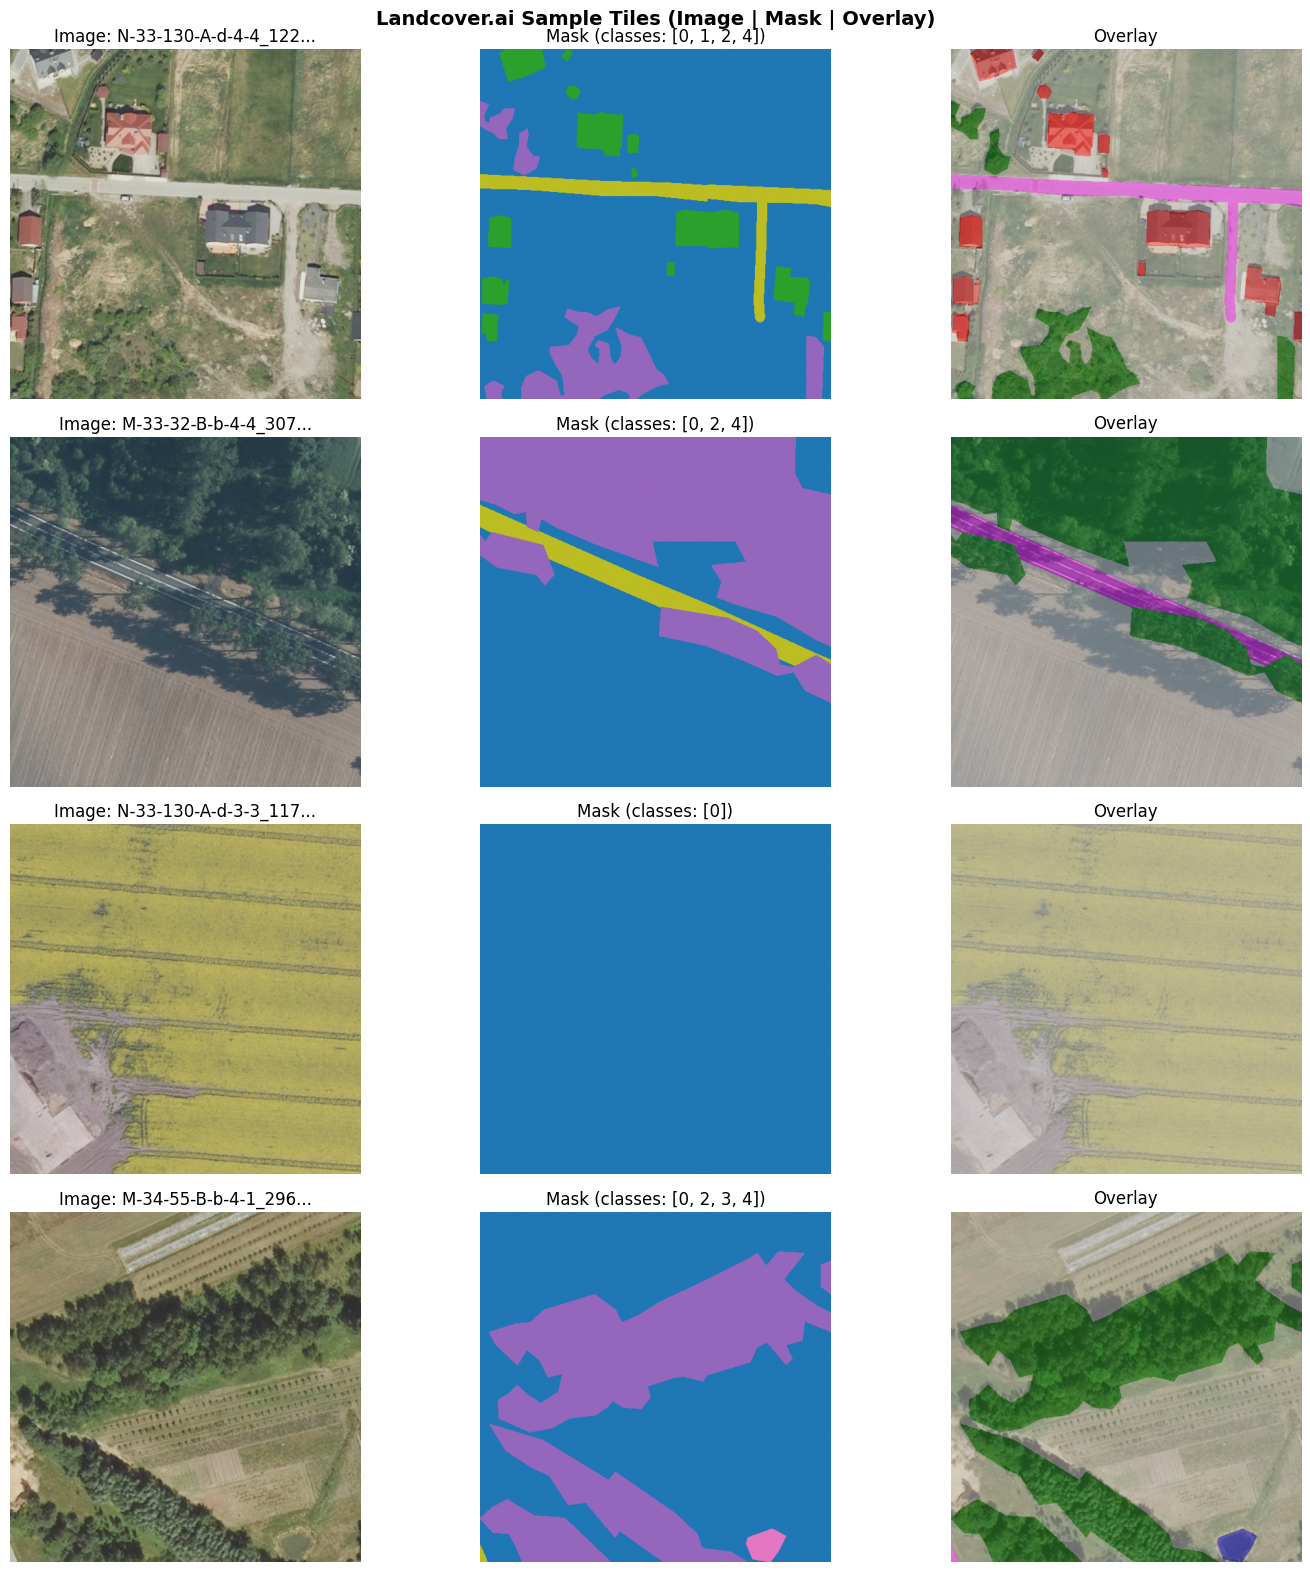

✓ Saved sample_tiles_preview.png


In [7]:
# Load and visualize sample tiles
output_dir = LANDCOVER_DIR / 'output'

# Get some random tile names from training set
with open(LANDCOVER_DIR / 'train.txt') as f:
    train_tiles = [l.strip() for l in f.readlines()]

# Select random samples
np.random.seed(42)
sample_indices = np.random.choice(len(train_tiles), 4, replace=False)
sample_tiles = [train_tiles[i] for i in sample_indices]

print(f"Visualizing {len(sample_tiles)} sample tiles...")

fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.suptitle('Landcover.ai Sample Tiles (Image | Mask | Overlay)', fontsize=14, fontweight='bold')

for row, tile_name in enumerate(sample_tiles):
    # Load image and mask
    img_path = output_dir / f"{tile_name}.jpg"
    mask_path = output_dir / f"{tile_name}_m.png"
    
    img = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path))
    if mask.ndim == 3:
        mask = mask[:, :, 0]
    
    # Image
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(f'Image: {tile_name[:30]}...')
    axes[row, 0].axis('off')
    
    # Mask
    axes[row, 1].imshow(mask, cmap='tab10', vmin=0, vmax=5)
    axes[row, 1].set_title(f'Mask (classes: {np.unique(mask).tolist()})')
    axes[row, 1].axis('off')
    
    # Overlay
    mask_rgb = np.zeros((*mask.shape, 3))
    for class_id, color in CLASS_COLORS.items():
        mask_rgb[mask == class_id] = color
    overlay = 0.6 * (img / 255.0) + 0.4 * mask_rgb
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title('Overlay')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'sample_tiles_preview.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved sample_tiles_preview.png")

## 5. Analyze Class Distribution

Understanding class distribution is critical for setting up proper loss weights during training.

In [8]:
# Analyze class distribution across training set
print("=== Analyzing Class Distribution ===")
print("(This may take a few minutes for large datasets)")
print()

# Count pixels per class
class_counts = {i: 0 for i in range(NUM_CLASSES)}
total_pixels = 0

# Sample a subset for faster analysis (or use all for accurate weights)
SAMPLE_SIZE = min(1000, len(train_tiles))  # Adjust as needed
sample_tiles_for_analysis = np.random.choice(train_tiles, SAMPLE_SIZE, replace=False)

for tile_name in tqdm(sample_tiles_for_analysis, desc="Counting classes"):
    mask_path = output_dir / f"{tile_name}_m.png"
    if not mask_path.exists():
        continue
    
    mask = np.array(Image.open(mask_path))
    if mask.ndim == 3:
        mask = mask[:, :, 0]
    
    for class_id in range(NUM_CLASSES):
        class_counts[class_id] += (mask == class_id).sum()
    total_pixels += mask.size

print(f"\nAnalyzed {SAMPLE_SIZE} tiles ({total_pixels:,} total pixels)")
print()
print("Class Distribution:")
print("-" * 50)

class_frequencies = {}
for class_id in range(NUM_CLASSES):
    count = class_counts[class_id]
    pct = (count / total_pixels * 100) if total_pixels > 0 else 0
    class_frequencies[class_id] = count / total_pixels if total_pixels > 0 else 0
    print(f"  {class_id} ({CLASS_NAMES[class_id]:12s}): {count:>12,} pixels ({pct:>5.1f}%)")

=== Analyzing Class Distribution ===
(This may take a few minutes for large datasets)



Counting classes: 100%|██████████| 1000/1000 [00:02<00:00, 410.32it/s]


Analyzed 1000 tiles (262,144,000 total pixels)

Class Distribution:
--------------------------------------------------
  0 (background  ):  150,175,161 pixels ( 57.3%)
  1 (building    ):    2,288,607 pixels (  0.9%)
  2 (woodland    ):   86,465,136 pixels ( 33.0%)
  3 (water       ):   18,834,835 pixels (  7.2%)
  4 (road        ):    4,380,261 pixels (  1.7%)


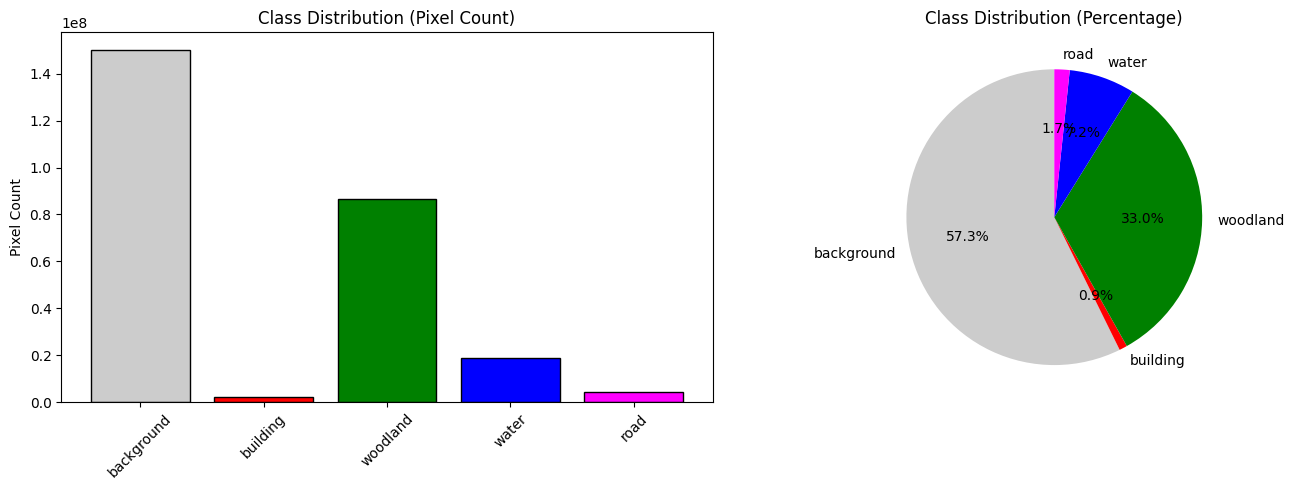

✓ Saved class_distribution.png


In [9]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = [CLASS_COLORS[i] for i in range(NUM_CLASSES)]
counts = [class_counts[i] for i in range(NUM_CLASSES)]
axes[0].bar(CLASS_NAMES, counts, color=colors, edgecolor='black')
axes[0].set_ylabel('Pixel Count')
axes[0].set_title('Class Distribution (Pixel Count)')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(counts, labels=CLASS_NAMES, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved class_distribution.png")

## 6. Calculate Class Weights for Training

We use inverse frequency weighting to handle class imbalance.

In [10]:
import torch

print("=== Calculating Class Weights ===")
print()

# Convert frequencies to tensor
freq_tensor = torch.tensor([class_frequencies[i] for i in range(NUM_CLASSES)])

# Method 1: Inverse frequency
weights_inv = 1.0 / freq_tensor
weights_inv = weights_inv / weights_inv.sum()  # Normalize

# Method 2: Inverse square root (less aggressive)
weights_sqrt = 1.0 / torch.sqrt(freq_tensor)
weights_sqrt = weights_sqrt / weights_sqrt.mean()  # Normalize to mean=1

# Method 3: Log inverse (even less aggressive)
weights_log = torch.log(1.0 / freq_tensor + 1)
weights_log = weights_log / weights_log.mean()

print("Class Frequencies:")
print(f"  {[f'{f:.4f}' for f in freq_tensor.tolist()]}")
print()
print("Weight Options:")
print(f"  Inverse frequency:      {[f'{w:.4f}' for w in weights_inv.tolist()]}")
print(f"  Inverse sqrt (recommended): {[f'{w:.4f}' for w in weights_sqrt.tolist()]}")
print(f"  Log inverse:            {[f'{w:.4f}' for w in weights_log.tolist()]}")
print()
print("Recommended: Use 'Inverse sqrt' weights for JaccardLoss")

=== Calculating Class Weights ===

Class Frequencies:
  ['0.5729', '0.0087', '0.3298', '0.0718', '0.0167']

Weight Options:
  Inverse frequency:      ['0.0090', '0.5932', '0.0157', '0.0721', '0.3099']
  Inverse sqrt (recommended): ['0.2618', '2.1208', '0.3450', '0.7393', '1.5330']
  Log inverse:            ['0.3616', '1.7006', '0.4992', '0.9676', '1.4710']

Recommended: Use 'Inverse sqrt' weights for JaccardLoss


In [11]:
# Save class weights for use in training notebook
weights_dict = {
    'class_names': CLASS_NAMES,
    'class_frequencies': freq_tensor.tolist(),
    'weights_inverse_sqrt': weights_sqrt.tolist(),
    'total_pixels_sampled': total_pixels,
    'num_tiles_sampled': SAMPLE_SIZE
}

import json
with open(LANDCOVER_DIR / 'class_weights.json', 'w') as f:
    json.dump(weights_dict, f, indent=2)

print("✓ Saved class_weights.json")
print()
print("To use in training notebook:")
print("```python")
print("import json")
print("with open('../data/class_weights.json') as f:")
print("    weights_dict = json.load(f)")
print("class_weights = torch.tensor(weights_dict['weights_inverse_sqrt']).to(device)")
print("```")

✓ Saved class_weights.json

To use in training notebook:
```python
import json
with open('../data/class_weights.json') as f:
    weights_dict = json.load(f)
class_weights = torch.tensor(weights_dict['weights_inverse_sqrt']).to(device)
```


In [12]:
print("=== Preprocessing Summary ===")
print()
print(f"Dataset: Landcover.ai v1")
print(f"Classes: {CLASS_NAMES}")
print(f"Tile size: 512×512")
print()
print(f"Train tiles: {len(train_tiles):,}")
print(f"Val tiles: Check val.txt")
print(f"Test tiles: Check test.txt")
print()
print("Output files:")
print(f"  - class_weights.json")
print(f"  - sample_tiles_preview.png")
print(f"  - class_distribution.png")
print()
print("✓ Preprocessing complete!")

=== Preprocessing Summary ===

Dataset: Landcover.ai v1
Classes: ['background', 'building', 'woodland', 'water', 'road']
Tile size: 512×512

Train tiles: 7,470
Val tiles: Check val.txt
Test tiles: Check test.txt

Output files:
  - class_weights.json
  - sample_tiles_preview.png
  - class_distribution.png

✓ Preprocessing complete!
